# Welter issue #9
## Generate synthetic, noised-up two-temperature model spectra, then naively fit a single temperature model to it.
### Part 1- Can you dig it?

Michael Gully-Santiago  
Wednesday, January 6, 2015  

CAANNN YOUUUU DIGGG ITTTT

In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt

In [2]:
% matplotlib inline
% config InlineBackend.figure_format = 'retina'
import seaborn as sns
sns.set_context('notebook')

# Facts

So, we are going to add two different temperature spectra together to create a *mixture model*:

$$ \mathsf{M}_{mix} = c \cdot \mathsf{M}_A(\Theta_A, \phi_{\mathsf{P}}) + (1-c) \cdot \mathsf{M}_B(\Theta_B, \phi_{\mathsf{P}}) $$

The $\phi_{\mathsf{P}}$ parameters will be the same.  The $\Theta$ parameters will be identical except for different effective temperatures:

$$ \Theta_A = [\theta_{A,\ast}, \theta_{ext}] $$

with:   

$$\theta_{A,\ast} = \{T_{\textrm{eff}, A}, \log g, [{\rm Fe}/{\rm H}] \}$$  
$$\theta_{B,\ast} = \{T_{\textrm{eff}, B}, \log g, [{\rm Fe}/{\rm H}] \}$$

But then we are going to *save* the noised up model as if it is *data*:

$$ \mathsf{D}_{syn} = \mathsf{M}_{mix} + \mathsf{R}$$

Where $\mathsf{R}$ is a single draw from the noise model, but I'm not quite sure how to illustrate that here.

## Getting the fluxes right.

It will be easy to save fake data.  We have already fit models to the data, and have noise estimates and calibration parameters.  The one tricky thing is that Starfish automatically normalizes the stellar fluxes from the model grids.  This makes sense for most cases, but in this case it is the wrong thing to do, since we care about the relative fluxes of the stars.  To fix this problem we will un-normalize the spectra by calculating their bolometric flux ratio, $r$, before normalization: 

$$r = F_{B,bol}/F_{A,bol}$$  
with:    
$$F_{B,bol} = \int{f_{B, \lambda}}{d\lambda}$$ 
$$F_{A,bol} = \int{f_{A, \lambda}}{d\lambda}$$

So: 
$$f_{B, \lambda} = r \cdot \hat f_{B, \lambda}$$  
where $\hat f$ denotes the normalized version of $f$.  The $\mathsf{M}$ terms above assume the un-normalized $f$.  (*n.b* Technically what we are doing is leaving $f_{A, \lambda}$ as normalized, and scaling $f_{B, \lambda}$ to ensure that their relative flux ratio is correct.  This choice makes it so that we don't have to change too much else in the fitting procedure.)

## Read in all the data.
No spot-checking necessary, since we already did that in the previous notebook.

In [3]:
import pandas as pd

In [4]:
sns.set_context('paper', font_scale=1.6)
sns.set_style('ticks')

In [5]:
sf_dat = pd.read_csv('../data/analysis/IGRINS_ESPaDOnS_run01_last10kMCMC.csv')
sf_dat.rename(columns={"m_val_x":"m_val"}, inplace=True)
del sf_dat['m_val_y']

In [6]:
sf_dat.head()

,m_val,number,wl_center,wl_end,wl_start,Teff_05p,Teff_50p,Teff_95p,logg_05p,logg_50p,...,SA_05p,SA_50p,SA_95p,LA_05p,LA_50p,LA_95p,ll_05p,ll_50p,ll_95p,m_int
0,0,0,5180.62500,5199.9292,5161.3208,3671.597583,3734.931152,3918.759131,3.757152,3.929592,...,4.130559,4.424212,4.735918,-1.030014,-0.915195,-0.820424,56.789884,72.114952,82.728920,0
1,1,1,5231.25700,5262.5311,5199.9829,3910.707983,3991.772217,4062.312549,3.531365,3.655367,...,3.515317,3.773452,4.024213,-1.249743,-1.176541,-1.078180,35.295181,41.962921,52.413920,1
2,2,2,5294.98655,5327.4005,5262.5726,3850.192407,3990.523193,4186.905322,3.815876,3.936076,...,3.121204,3.315826,3.529300,-1.314615,-1.223884,-1.141970,36.250294,46.100685,56.028513,2
3,3,3,5360.99580,5394.5496,5327.4420,3846.459961,3923.694824,3995.909888,3.585957,3.762359,...,2.058792,2.182574,2.324363,-1.328933,-1.267863,-1.195140,37.950161,43.088070,49.906529,3
4,4,4,5429.35055,5464.0826,5394.6185,3727.496973,3812.548828,3867.507104,3.572361,3.817147,...,2.110130,2.260994,2.406161,-1.200368,-1.147594,-1.093094,44.042196,48.723873,53.670507,4


# Experiment

In [8]:
import os

In [9]:
import yaml
import json

In [10]:
sf_out = '../sf/eo005/output/LkCa4_eo005/run01/config.yaml'

In [11]:
!pwd

/Users/gully/GitHub/welter/notebooks


In [12]:
spec = []

In [13]:
os.chdir('/Users/gully/GitHub/welter/notebooks')

In [14]:
for Teff in [3300, 3800, 4100]:
    
    with open(sf_out, mode='r') as outfile:
        config = yaml.load(outfile)

    config['Theta']['grid'] = [Teff, 3.7, 0.0]

    with open(sf_out, mode='w') as outfile:
        outfile.write(yaml.dump(config))

    os.chdir('../sf/eo005/output/LkCa4_eo005/run01/')
    os.system('star.py --generate')
    os.system('mv s0_o0spec.json s0_o0spec_{:04d}.json'.format(Teff))
    os.chdir('/Users/gully/GitHub/welter/notebooks')

    with open('../sf/eo005/output/LkCa4_eo005/run01/s0_o0spec_{:04d}.json'.format(Teff)) as f:
        spec.append(json.load(f))

## `spec` is a list of dictionaries.

In [15]:
spec[0]['wl'][0:6]

[5464.1332999999995,
 5464.1711,
 5464.209,
 5464.2474,
 5464.2853000000005,
 5464.3231]

In [16]:
n_els = len(spec[0]['wl'])
n_els

1897

In [17]:
x = np.arange(n_els)/n_els
x

array([  0.00000000e+00,   5.27148129e-04,   1.05429626e-03, ...,
         9.98418556e-01,   9.98945704e-01,   9.99472852e-01])

In [18]:
from ipywidgets import interact

In [20]:
f=0.7

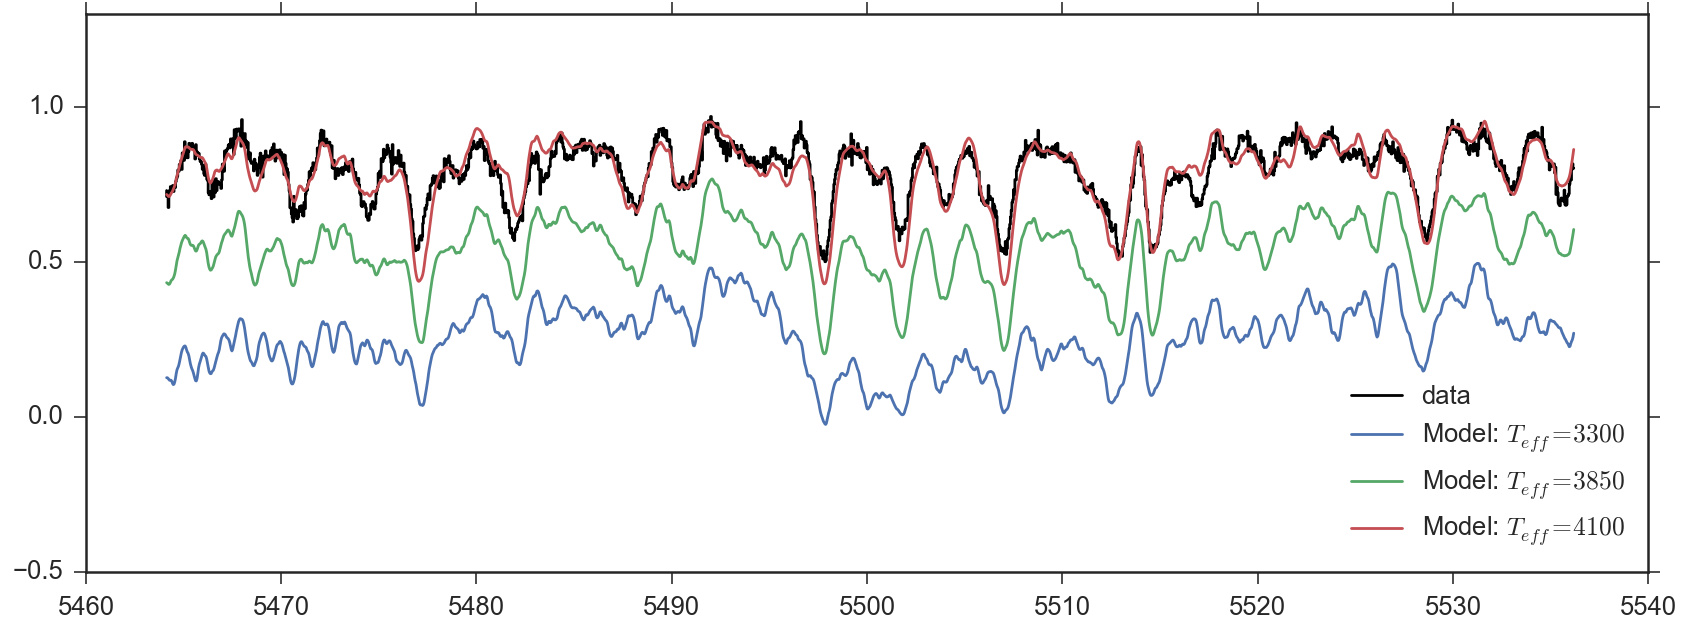

In [21]:
plt.figure(figsize=(14, 5))
y1, y2, y3 = (np.array(spec[0]['model'])-0.50, 
              np.array(spec[1]['model'])-0.25, 
              np.array(spec[2]['model'])+0.0)

#corr = (1.0 + x * 0.0)
m2 = (np.array(spec[2]['model'])*f + (1.0-f)*np.array(spec[0]['model']))

plt.step(spec[0]['wl'], spec[0]['data'], 'k', label='data')
plt.plot(spec[0]['wl'], y1, label='Model: $T_{eff} = 3300$')
plt.plot(spec[1]['wl'], y2, label='Model: $T_{eff} = 3850$')
plt.plot(spec[2]['wl'], y3, label='Model: $T_{eff} = 4100$')
#plt.plot(spec[2]['wl'], m2, label='Model: mix')

#plt.xlim(7855, 8055)
plt.ylim(-0.5, 1.3)
plt.legend(loc='best');

In [22]:
def plot_models(f):
    plt.figure(figsize=(14, 5))
    y1, y2, y3 = (np.array(spec[0]['model'])-0.50, 
                  np.array(spec[1]['model'])-0.25, 
                  np.array(spec[2]['model'])+0.0)

    #corr = (1.0 + x * 0.0)
    m2 = (np.array(spec[2]['model'])*f + (1.0-f)*np.array(spec[0]['model']))

    plt.step(spec[0]['wl'], spec[0]['data'], 'k', label='data')
    plt.plot(spec[0]['wl'], y1, label='Model: $T_{eff} = 3300$')
    plt.plot(spec[1]['wl'], y2, label='Model: $T_{eff} = 3850$')
    plt.plot(spec[2]['wl'], y3, label='Model: $T_{eff} = 4100$')
    plt.plot(spec[2]['wl'], m2, label='Model: mix')

    #plt.xlim(7855, 8055)
    plt.ylim(-0.5, 1.3)
    plt.legend(loc='best');

<function __main__.plot_models>

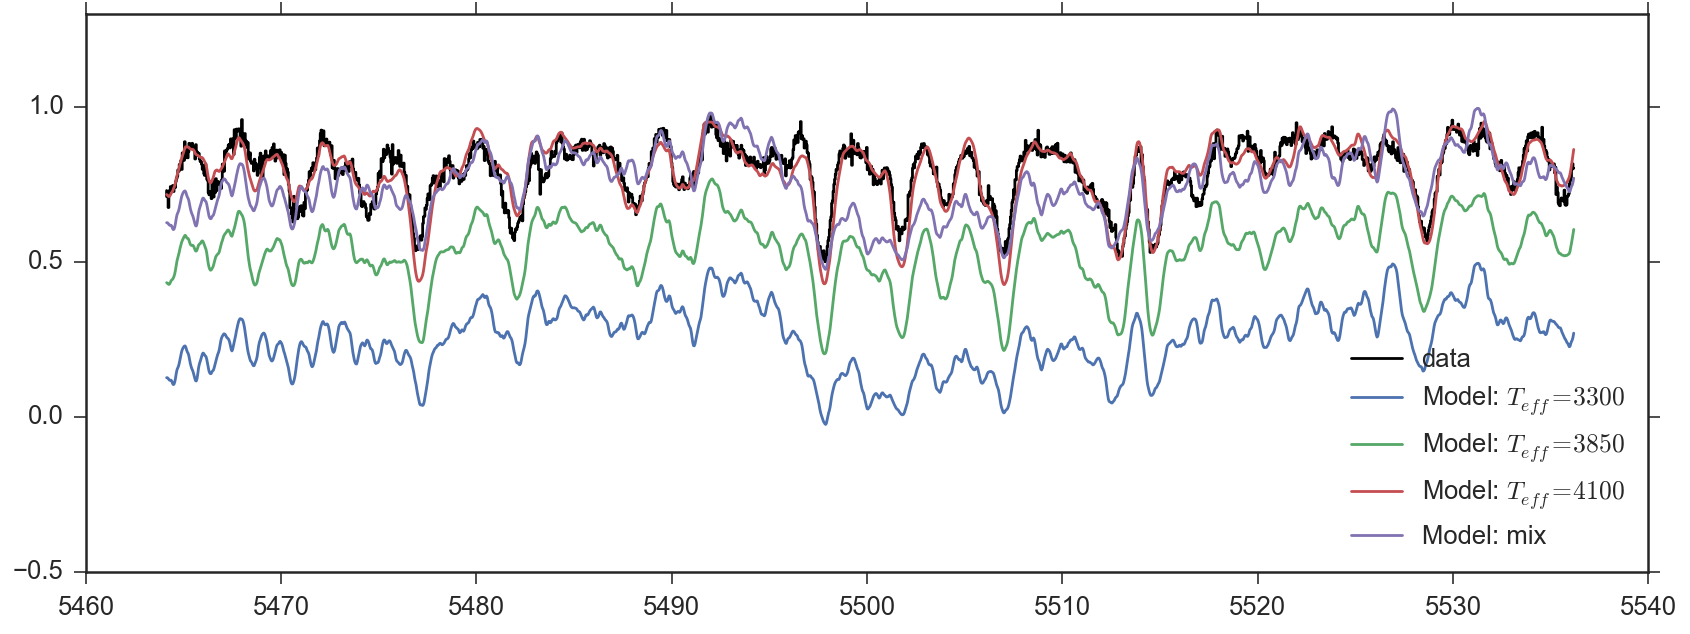

In [23]:
interact(plot_models, f=(0,1,0.05))

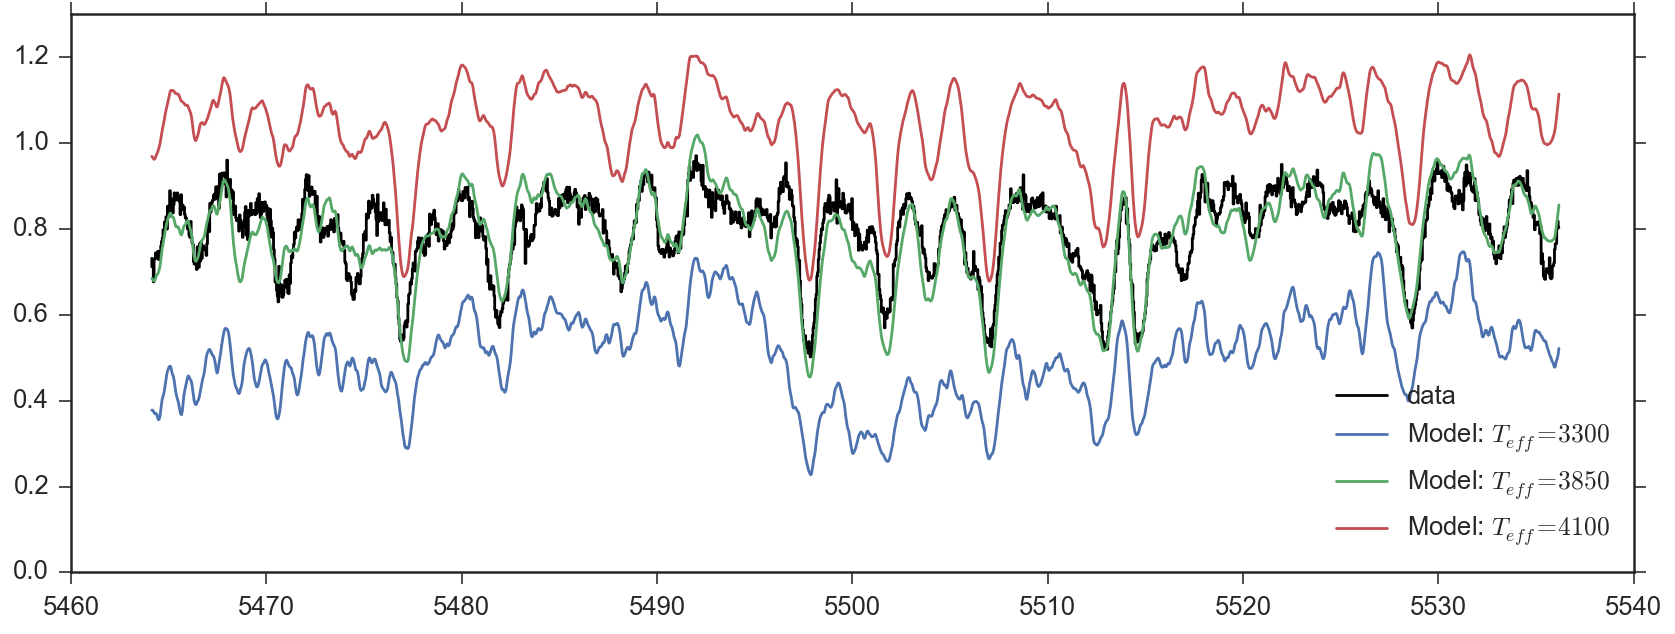

In [25]:
plt.figure(figsize=(14, 5))
y1, y2, y3 = (np.array(spec[0]['model'])-0.25, 
              np.array(spec[1]['model'])+0.0, 
              np.array(spec[2]['model'])+0.25)

plt.step(spec[0]['wl'], spec[0]['data'], 'k', label='data')
plt.plot(spec[0]['wl'], y1, label='Model: $T_{eff} = 3300$')
plt.plot(spec[1]['wl'], y2, label='Model: $T_{eff} = 3850$')
plt.plot(spec[2]['wl'], y3, label='Model: $T_{eff} = 4100$')

#plt.xlim(7855, 8055)
plt.ylim(0, 1.3)
plt.legend(loc='best');

Overplot the not-normalized raw models.

In [26]:
import Starfish
from Starfish.grid_tools import PHOENIXGridInterfaceNoAlpha as PHOENIX
import numpy as np
mygrid = PHOENIX(norm=False, base='/Users/gully/GitHub/Starfish/libraries/raw/PHOENIX/')

In [27]:
p_A = np.array([4100, 3.5, 0.0])
flux_A, hdr_A = mygrid.load_flux(p_A)
p_B = np.array([3300, 3.5, 0.0])
flux_B, hdr_B = mygrid.load_flux(p_B)

(4000, 25000)

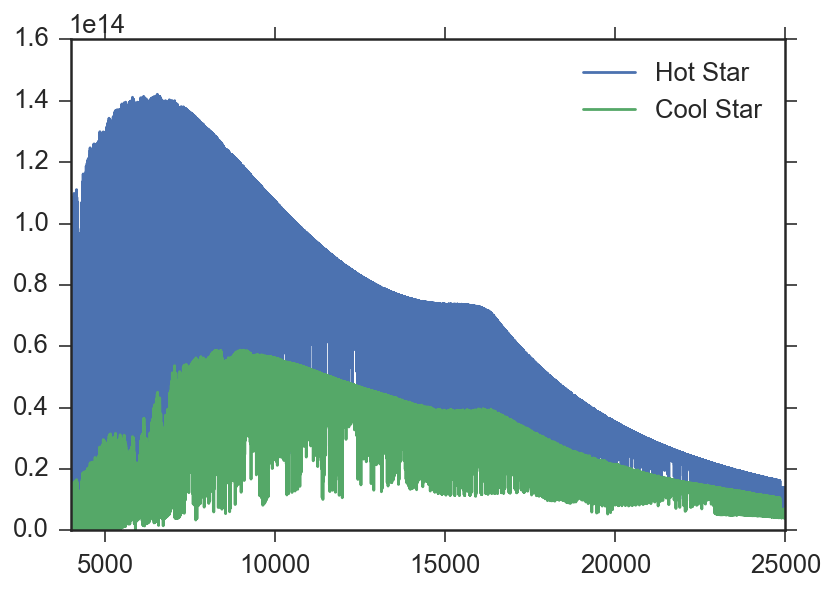

In [28]:
plt.plot(mygrid.wl, flux_A, label='Hot Star')
plt.plot(mygrid.wl, flux_B, label='Cool Star')
plt.legend(loc='best')
plt.xlim(4000, 25000)

In [ ]:
plt.figure(figsize=(14, 5))
y1, y2, y3 = (np.array(spec[0]['model'])-0.25, 
              np.array(spec[1]['model'])+0.0, 
              np.array(spec[2]['model'])+0.25)

plt.step(spec[0]['wl'], spec[0]['data'], 'k', label='data')
#plt.plot(spec[0]['wl'], y1, label='Model: $T_{eff} = 3300$')
plt.plot(spec[1]['wl'], y2, label='Model: $T_{eff} = 3850$')
#plt.plot(spec[2]['wl'], y3, label='Model: $T_{eff} = 4100$')

Data munge a small section.

In [ ]:
const = 1.4e14
gi = (mygrid.wl > 5460) & (mygrid.wl < 5540)
wl = mygrid.wl[gi]
fl_A = flux_A[gi]
fl_B = flux_B[gi]

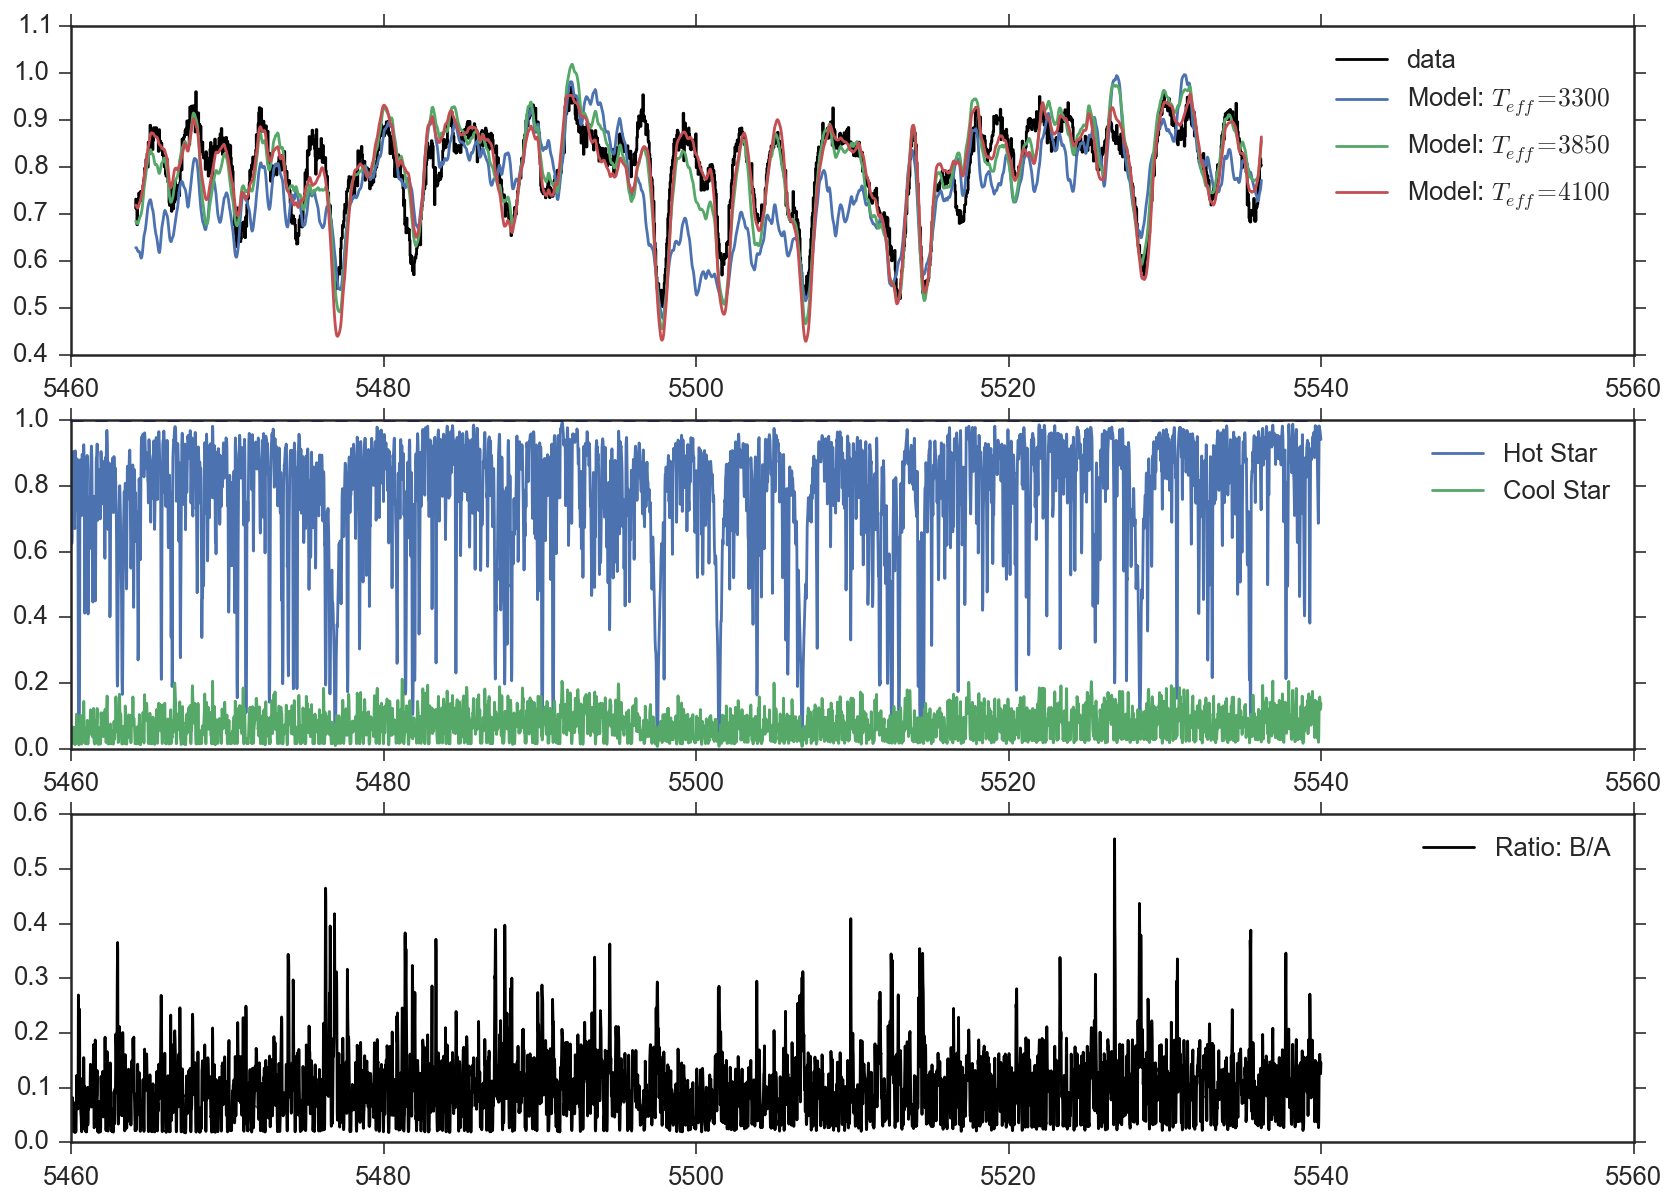

In [52]:
plt.figure(figsize=(14, 10))

plt.subplot('311')
y1, y2, y3 = (np.array(spec[0]['model'])-0.0, 
              np.array(spec[1]['model'])+0.0, 
              np.array(spec[2]['model'])+0.0)

plt.step(spec[0]['wl'], spec[0]['data'], 'k', label='data')
plt.plot(spec[0]['wl'], y1, label='Model: $T_{eff} = 3300$')
plt.plot(spec[1]['wl'], y2, label='Model: $T_{eff} = 3850$')
plt.plot(spec[2]['wl'], y3, label='Model: $T_{eff} = 4100$')
plt.legend(loc='best')
plt.xlim(5460, 5560);


plt.subplot('312')
plt.plot(wl, fl_A/const, label='Hot Star')
plt.plot(wl, fl_B/const, label='Cool Star')
plt.plot((5460, 5540), (1,1), 'b--')
plt.legend(loc='best');
plt.xlim(5460, 5560);

plt.subplot('313')
plt.plot(wl, fl_B/fl_A, 'k', label='Ratio: B/A')
plt.legend()

plt.xlim(5460, 5560);